This post will be a simple introduction to the lolesports API and how to make your own stats about matches from Worlds 2019.

You can find the notebook with all the code and the dataset on Github : https://github.com/HextechLab/Worlds2019

## Gather data

The first need you need to make stats is data. And in the case of League of Legends esports, the data is not that easily accessible. There are some endpoints used by the lolesports website that are exactly what we want but are not publicly documented, but after some analysis about how the website work, we can understand what are these usefull endpoints.

In [1]:
import requests, json

url_tournament = "http://api.lolesports.com/api/v1/scheduleItems?leagueId=9"
r  = requests.get(url_tournament)
raw_tournament_data = json.loads(r.text)

In [2]:
raw_tournament_data.keys()

dict_keys(['scheduleItems', 'highlanderTournaments', 'teams', 'highlanderRecords', 'players'])

here we are interested in the "highlanderTournaments" field, it contains informations and all Worlds tournament since 2015. We will focus on the 2019 one : 

In [3]:
worlds_2019 = raw_tournament_data["highlanderTournaments"][4]
worlds_2019.keys()

dict_keys(['id', 'title', 'description', 'leagueReference', 'roles', 'queues', 'rosters', 'published', 'breakpoints', 'brackets', 'liveMatches', 'startDate', 'endDate', 'leagueId', 'platformIds', 'gameIds', 'league'])

We will save the tournament ID for later.

In [4]:
tournament_id = worlds_2019["id"]

The bracket field contains most of the information about the structure of the tournament and matches being played in it. Unlike the Riot Games API, matches and games are two differents entities, as matches are what we call B.O. (BO3, BO5...) and are composed by one or more games. We will gather the gameId of each game, the realm (aka server) and the group name for filtering purpose.

In [5]:
brackets = worlds_2019["brackets"]

matches = []
games = {}

for bracket_id in brackets:
    bracket = brackets[bracket_id]
    
    for match_id in bracket["matches"]:
        match = bracket["matches"][match_id]
        
        for game_uuid in match['games']:
            
            game = match['games'][game_uuid]
            
            if 'gameId' in game:
                matches.append(match_id)
                games[game_uuid] = {"matchHistoryId":game['gameId'], "realm":game["gameRealm"], "groupName":bracket["groupName"]}

In [6]:
games[next(iter(games.keys()))]

{'matchHistoryId': '1070986',
 'realm': 'ESPORTSTMNT06',
 'groupName': 'play_in_elim'}

## Get the hashes

Esports matches are available on the official match history website.

In [7]:
base_match_history_url = "https://matchhistory.na.leagueoflegends.com/en/#match-details/{}/{}"
base_match_history_url.format(games[next(iter(games.keys()))]["realm"],games[next(iter(games.keys()))]["matchHistoryId"])

'https://matchhistory.na.leagueoflegends.com/en/#match-details/ESPORTSTMNT06/1070986'

However, this link won't work in this state as we miss a hash. Fortunately, we can find this hash in another endpoint.

In [8]:
match_id = next(iter(games.keys()))
base_match_url = "http://api.lolesports.com/api/v2/highlanderMatchDetails?tournamentId={}&matchId={}"
r  = requests.get(base_match_url.format(tournament_id,matches[0]))
match_data = json.loads(r.text)

In [9]:
match_data.keys()

dict_keys(['teams', 'players', 'scheduleItems', 'gameIdMappings', 'videos', 'htmlBlocks'])

We can get advanced informations about players, team and even videos links of the games. But most importantly for use, we can find the hashes needed.

In [10]:
for i in match_data["gameIdMappings"]:
    print(i)

{'id': '7a7a436a-43cb-4dc3-b9fe-11d58bcb5c64', 'gameHash': '9e3f5534655e9c51'}
{'id': 'a00bb3da-8bb1-4adf-a600-1173ac82b80c', 'gameHash': '1230c6f4af180085'}
{'id': '7bb7c407-878d-4876-baad-1c16542f4983', 'gameHash': '1787d1ea36a382c3'}
{'id': '98e43133-f89d-4087-a3c6-4ab012d8cba5', 'gameHash': '997c81ff2a1f4f9d'}


Call all the matches to get all hashes.

In [11]:
for match_id in matches:
    r  = requests.get(base_match_url.format(tournament_id,match_id))
    match_data = json.loads(r.text)
    for i in match_data["gameIdMappings"]:
        games[i["id"]]["hash"] = i["gameHash"]

With this hash, we are able to make the match history work.

In [12]:
base_match_history_url = "https://matchhistory.na.leagueoflegends.com/en/#match-details/{}/{}?gameHash={}"
base_match_history_url.format(games[next(iter(games.keys()))]["realm"],games[next(iter(games.keys()))]["matchHistoryId"],games[next(iter(games.keys()))]["hash"])

'https://matchhistory.na.leagueoflegends.com/en/#match-details/ESPORTSTMNT06/1070986?gameHash=1787d1ea36a382c3'

## Get the data

Now we have all informations needed to gather games data. We will use the ACS, which is the service Riot uses for the match history. URL are of this form : 

In [13]:
base_match_history_stats_url = "https://acs.leagueoflegends.com/v1/stats/game/{}/{}?gameHash={}"
base_match_history_stats_url.format(games[next(iter(games.keys()))]["realm"],games[next(iter(games.keys()))]["matchHistoryId"],games[next(iter(games.keys()))]["hash"])

'https://acs.leagueoflegends.com/v1/stats/game/ESPORTSTMNT06/1070986?gameHash=1787d1ea36a382c3'

ACS shouldn't be sued like that and is only tolerated to use for lolesports games as they are not available through the Riot Games API. My best advice here is to call the games one by one to be sure not to reach any rate limit.

In [14]:
all_games_data = {}

for k, v in games.items():
    url = base_match_history_stats_url.format(v["realm"],v["matchHistoryId"],v["hash"])
    all_games_data[k] = requests.get(url).json()

In [15]:
len(all_games_data)

93

## Analysis

At this point we have the raw data from all matches of the Worlds 2019. In this example, we will focus on simple stats like banrate, pickrate and winrate.

### Prepare the dataset

Lets define some functions to pick some specific information

In [16]:
def get_team_bans(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_picks(game_data):
    team_picks = {100:[],200:[]}
    for p in game_data["participants"]:
        team_picks[p["teamId"]].append(p["championId"])
    return team_picks
    
def get_team_tag(game_data):
    team_tag = {}
    for p in game_data["participantIdentities"]:
        team_tag[100 if p["participantId"] <= 5 else 200] = p["player"]["summonerName"].split(" ")[0]
    return team_tag
    
role_order = {
    0:"top",
    1:"jungle",
    2:"mid",
    3:"bot",
    4:"supp"
}

Using the previously defined functions, create a list where each element is one pick or ban

In [17]:
from static_data import ddragon
dd = ddragon.ddragon()

pick_ban_data = []

for i in all_games_data:
    team_bans = get_team_bans(all_games_data[i])
    team_picks = get_team_picks(all_games_data[i])
    team_tag = get_team_tag(all_games_data[i])
    
    group = games[i]["groupName"]
    for team in [100,200]:
        side = "Blue" if team == 100 else "Red"
        tag = team_tag[team]
        win = all_games_data[i]["teams"][0 if team == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[team]:
            
            row = {
                "group":group,
                "side":side,
                "tag":tag,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[team]):
            
            row = {
                "group":group,
                "side":side,
                "tag":tag,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name,
                "role":role_order[n_role]
            }
            pick_ban_data.append(row)

Manage the list with pandas

In [18]:
import pandas as pd
df = pd.DataFrame(pick_ban_data)
df

,group,side,tag,win,type,championId,champion,role
0,play_in_elim,Blue,HKA,True,ban,79,Gragas,NaN
1,play_in_elim,Blue,HKA,True,ban,18,Tristana,NaN
2,play_in_elim,Blue,HKA,True,ban,41,Gangplank,NaN
3,play_in_elim,Blue,HKA,True,ban,421,Rek'Sai,NaN
4,play_in_elim,Blue,HKA,True,ban,60,Elise,NaN
...,...,...,...,...,...,...,...,...
1854,play_in_groups,Red,MG,False,pick,84,Akali,top
1855,play_in_groups,Red,MG,False,pick,59,Jarvan IV,jungle
1856,play_in_groups,Red,MG,False,pick,3,Galio,mid
1857,play_in_groups,Red,MG,False,pick,498,Xayah,bot


### Manipulating the dataset

Calculate the banrate of champions

In [19]:
banrate = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /len(games)
)

banrate.head(10)

champion
Pantheon     0.989247
Qiyana       0.688172
Syndra       0.559140
Renekton     0.483871
LeBlanc      0.397849
Kayle        0.354839
Akali        0.311828
Xayah        0.311828
Gangplank    0.311828
Gragas       0.279570
Name: championId, dtype: float64

Calculate the pickrate of champions

In [20]:
pickrate = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /len(games)
)

pickrate.head(10)

champion
Kai'Sa       0.559140
Xayah        0.505376
Lee Sin      0.483871
Nautilus     0.408602
Rakan        0.387097
Akali        0.365591
Gragas       0.344086
Gangplank    0.344086
Thresh       0.311828
Renekton     0.268817
Name: championId, dtype: float64

Calculate the winrate

In [21]:
wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Malphite        1.000000
Vayne           1.000000
Draven          1.000000
Poppy           1.000000
Pantheon        1.000000
Urgot           1.000000
Fiddlesticks    1.000000
Varus           1.000000
Jax             1.000000
Taliyah         0.857143
Name: championId, dtype: float64

Calculate the presence

In [22]:
presence = pickrate.add(banrate, fill_value=0)
presence

champion
Aatrox     0.129032
Akali      0.677419
Alistar    0.161290
Anivia     0.010753
Ashe       0.075269
             ...   
Yasuo      0.236559
Yuumi      0.376344
Ziggs      0.010753
Zilean     0.010753
Zoe        0.053763
Name: championId, Length: 96, dtype: float64

Combine all of this and add the presence rate in a new dataframe

In [23]:
df2 = pd.DataFrame([banrate,pickrate,winrate, presence]).T.fillna(0)
df2.columns = ["banrate", "pickrate", "winrate", "presence"]

df2

,banrate,pickrate,winrate,presence
Pantheon,0.989247,0.010753,1.000000,1.000000
Qiyana,0.688172,0.193548,0.555556,0.881720
Syndra,0.559140,0.268817,0.440000,0.827957
Renekton,0.483871,0.268817,0.600000,0.752688
LeBlanc,0.397849,0.182796,0.529412,0.580645
...,...,...,...,...
Sona,0.000000,0.010753,0.000000,0.010753
Poppy,0.000000,0.010753,1.000000,0.010753
Lulu,0.000000,0.010753,0.000000,0.010753
Lux,0.000000,0.010753,0.000000,0.010753


Sort the dataframe how you want

In [24]:
df2.sort_values("presence",ascending=False)

,banrate,pickrate,winrate,presence
Pantheon,0.989247,0.010753,1.000000,1.000000
Qiyana,0.688172,0.193548,0.555556,0.881720
Syndra,0.559140,0.268817,0.440000,0.827957
Xayah,0.311828,0.505376,0.574468,0.817204
Renekton,0.483871,0.268817,0.600000,0.752688
...,...,...,...,...
Ziggs,0.000000,0.010753,0.000000,0.010753
Anivia,0.000000,0.010753,0.000000,0.010753
Xin Zhao,0.000000,0.010753,0.000000,0.010753
Kalista,0.010753,0.000000,0.000000,0.010753


Having graphs is good too, so we'll create a bar chart with wins, losses and bans. We'll create another dataframe for this purpose.

In [25]:
bans = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

losses = picks - wins

presence = picks+bans

df3 = pd.DataFrame([picks, wins, losses, bans, presence]).T.fillna(0)
df3.columns = ["picks", "wins", "losses", "bans", "presence"]
df3

,picks,wins,losses,bans,presence
Kai'Sa,52.0,29.0,23.0,11.0,63.0
Xayah,47.0,27.0,20.0,29.0,76.0
Lee Sin,45.0,23.0,22.0,11.0,56.0
Nautilus,38.0,18.0,20.0,19.0,57.0
Rakan,36.0,19.0,17.0,22.0,58.0
...,...,...,...,...,...
Pantheon,1.0,1.0,0.0,92.0,93.0
Lulu,1.0,0.0,0.0,0.0,0.0
Lux,1.0,0.0,0.0,0.0,0.0
Malphite,1.0,1.0,0.0,0.0,0.0


### Visualizing the data

Here is a stacked bar graph to represent the 15 most present champions that have been picked or ban.

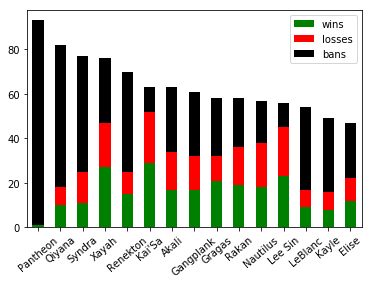

In [33]:
# Sorting the dataframe, first items are the most present
df3.sort_values("presence", ascending=False, inplace=True)

# Take only the interesting columns for the graph
sorted_champions =  df3[["wins", "losses", "bans"]]

# Take the top 15
top_sorted_champions = sorted_champions[:15]

#Plot the result as stacked bar, change the colors at will, rot=40 being the label rotaion at the bottom
top_sorted_champions.plot(kind="bar", stacked=True, color=["green","red","black"], rot=40)

The graph is nice and all, but we always can do better, and a little customization like adding champion icon and other details is possible. Here we go.

In [27]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

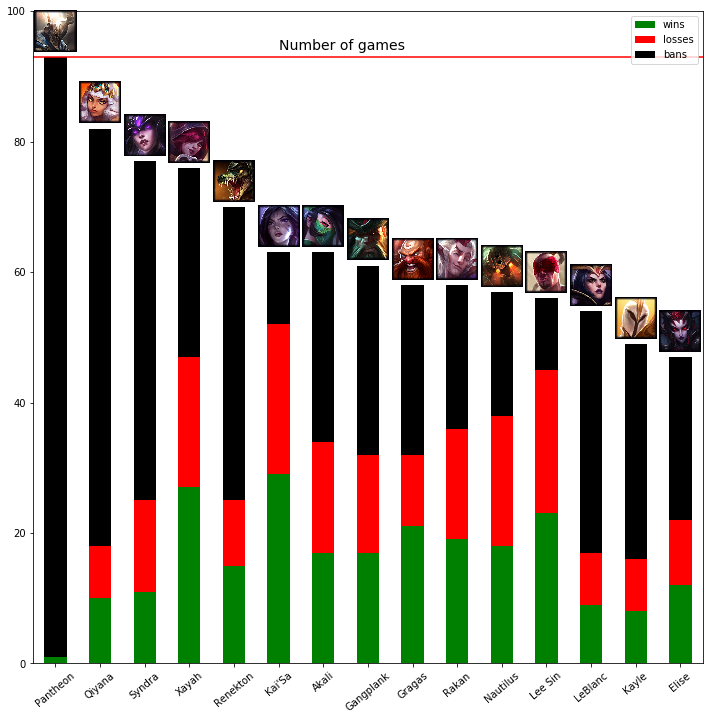

In [28]:
top_number = 15

# Sort champions by presence and select the top
df_champions_presence = df3.sort_values("presence", ascending=False)[:top_number]

# Define the graph like previously, but make it larger
plt = df_champions_presence[["wins", "losses", "bans"]].plot(kind="bar", stacked=True, color=["green","red","black"], rot=40, figsize=(12,12), ylim=(0,100))

# Add a line to represent the maximum number of time a champion could have been picked or banned
plt.axhline(y=len(all_games_data), color='r', linestyle='-')
plt.text(5, 94, "Number of games", fontsize=14)

# For each champion, we add its icon on top of the bar
position = 0
for champion,stats in df_champions_presence.iterrows():
    
    # Get the image url and fit it in a "box"
    image = mpimg.imread(dd.getChampion(champion).image)
    imagebox = OffsetImage(image, zoom=0.35)
    
    # Position the box where it should 
    ab = AnnotationBbox(imagebox, (position, stats["presence"] + 4), frameon=False)
    
    # Add the box to the graph
    plt.add_artist(ab)

    position += 1


plt

For the fun, make another graph with the champions sorted by picks and remove the bans.

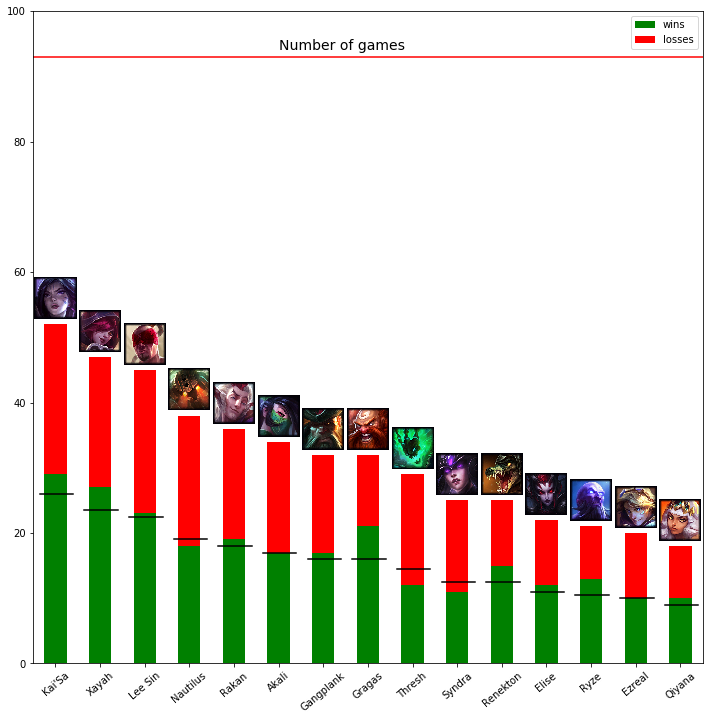

In [29]:
# Sort champions by pick and select the top
df_champions_pick = df3.sort_values("picks", ascending=False)[:top_number]

# Define the graph
plt = df_champions_pick[["wins", "losses"]].plot(kind="bar", stacked=True, color=["green","red"], rot=40, figsize=(12,12), ylim=(0,100))

# Add the line for the number of games
plt.axhline(y=len(all_games_data), color='r', linestyle='-')
plt.text(5, 94, "Number of games", fontsize=14)

# Add the icon for each champion
position = 0
for champion,stats in df_champions_pick.iterrows():
    
    # Get the image url and fit it in a "box"
    image = mpimg.imread(dd.getChampion(champion).image)
    imagebox = OffsetImage(image, zoom=0.35)
    
    # Position the box where it should 
    ab = AnnotationBbox(imagebox, (position, stats["picks"] + 4), frameon=False)
    
    # Add the box to the graph
    plt.add_artist(ab)
    
    
    v_position = position/top_number
    
    #Another usefull detail, add a line to represent half the picks, to show if the champion has a high winrate or not
    plt.axhline(y=stats["picks"]/2, color='black', linestyle='-', xmin=v_position+0.01, xmax=v_position+0.06)

    position += 1

plt

That's all for today, now you have the data, you know how to extract information from the data, and how to present it. It's your turn to practice and tell me who is the best KDA player or the best farmer.